In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
from scipy.special import binom
from sympy import binomial

In [2]:
# Parameters
l = 1.6  # L
dr = 0.15  # Distance between ears
theta = (18 / 180) * np.pi  # Half the speaker span
l1 = np.sqrt(l**2 + (dr / 2)**2 - (dr * l * np.sin(theta / 2)))  # L1
l2 = np.sqrt(l**2 + (dr / 2)**2 + (dr * l * np.sin(theta / 2)))  # L2
g = l1 / l2  # g
cs = 340.3  # Speed of sound
dl = abs(l2 - l1)  # Distance difference
tc = dl / cs  # Time delay
tau_s = 3
tau_c = 68e-6  # Time delay for a normal listening room
g = 0.985
fs = 44100
gamma_db = 7

$$
\gamma = 10^{\Gamma / 20}
$$ 

$$
\omega \tau_c
$$

In [3]:
def gamma_db2gain(db):
    return 10 ** (db / 20)

In [4]:
def compute_phi(g, gamma):
    return np.arccos((g * g * gamma * gamma + gamma * gamma - 1) / (2 * g * gamma * gamma))

In [5]:
def compute_band_edges(g, gamma, tau_c, fs):
    phi = compute_phi(g, gamma)
    bands = []
    
    f_nyquist = fs / 2
    omega_nyquist_tau = 2 * np.pi * f_nyquist * tau_c
    n_max = int(np.ceil(omega_nyquist_tau / (2 * np.pi))) + 1 
    
    for n in range(n_max):
        omega_tau_0 = (2*n+0)*np.pi - phi
        omega_tau_1 = (2*n+0)*np.pi + phi
        omega_tau_2 = (2*n+1)*np.pi - phi
        omega_tau_3 = (2*n+1)*np.pi + phi
        omega_tau_4 = (2*n+2)*np.pi - phi

        f0 = omega_tau_0 / (2 * np.pi * tau_c)
        f1 = omega_tau_1 / (2 * np.pi * tau_c)
        f2 = omega_tau_2 / (2 * np.pi * tau_c)
        f3 = omega_tau_3 / (2 * np.pi * tau_c)
        f4 = omega_tau_4 / (2 * np.pi * tau_c)

        if n == 0 and f0 < 0:
            f0 = 0
            omega_tau_0 = 0
        
        bands.append((omega_tau_0, omega_tau_1, f0, f1, 'b', 'Branch I'))
        bands.append((omega_tau_1, omega_tau_2, f1, f2, 'g', 'Branch P'))
        bands.append((omega_tau_2, omega_tau_3, f2, f3, 'r', 'Branch II'))
        bands.append((omega_tau_3, omega_tau_4, f3, f4, 'g', 'Branch P'))

    valid_index = None
    valid_bands = []
    for index, b in enumerate(bands):
        if b[3] <= fs/2:
            valid_bands.append(b)
        else:
            valid_index = index
            break
    
    b = bands[valid_index]
    valid_bands.append((b[0], omega_nyquist_tau, b[2], fs/2, b[4], b[5]))
    
    return valid_bands

In [6]:
gamma = gamma_db2gain(gamma_db)
bands = compute_band_edges(g, gamma, tau_c, fs)

for b in bands:
    print(b)

# Frequency and omega
f = np.arange(1, fs//2+1, 1)
w = 2 * np.pi * f
x = 2 * g * np.cos(w * tc)
r = gamma

(0, 0.4536993333487237, 0, 1061.8895820580437, 'b', 'Branch I')
(0.4536993333487237, 2.6878933202410695, 1061.8895820580437, 6291.0515944125455, 'g', 'Branch P')
(2.6878933202410695, 3.5952919869385167, 6291.0515944125455, 8414.830758528633, 'r', 'Branch II')
(3.5952919869385167, 5.829485973830862, 8414.830758528633, 13643.992770883133, 'g', 'Branch P')
(5.829485973830862, 6.73688464052831, 13643.992770883133, 15767.771934999222, 'b', 'Branch I')
(6.73688464052831, 8.971078627420656, 15767.771934999222, 20996.933947353722, 'g', 'Branch P')
(8.971078627420656, 9.42100804958507, 20996.933947353722, 22050.0, 'r', 'Branch II')


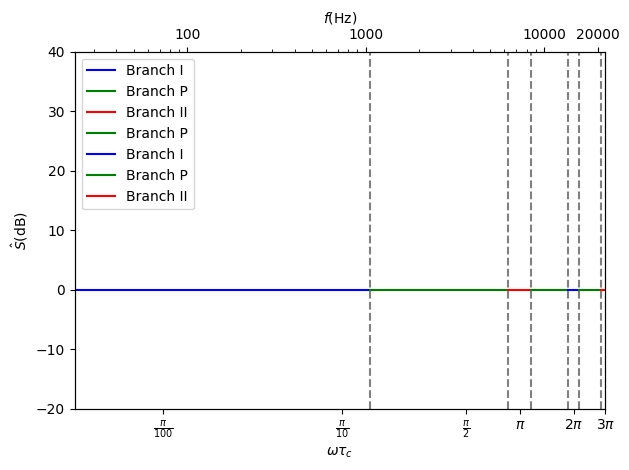

In [7]:
fig, ax1 = plt.subplots()

# Primary x-axis (w*tc)
for omega1, omega2, f1, f2, color, branch in bands:
    ax1.plot([omega1, omega2], [0, 0], color=color, label=branch)
    ax1.axvline(omega1, linestyle='--', color='gray')

ax1.set_xscale('log')
ax1.set_xlim(1 / 100, bands[-1][1])
ax1.set_xticks([np.pi / 100, np.pi / 10, np.pi / 2, np.pi, 2 * np.pi, 3 * np.pi])
ax1.set_xticklabels([r'$\frac{\pi}{100}$', r'$\frac{\pi}{10}$', r'$\frac{\pi}{2}$', r'$\pi$', r'$2\pi$', r'$3\pi$'])

ax1.xaxis.set_minor_locator(ticker.NullLocator())

# Calculate corresponding frequency ticks
major_freq_ticks = [100, 1000, 10000, 20000]
major_omega_tc_ticks = [2 * np.pi * f * tau_c for f in major_freq_ticks]

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())  # Align with primary x-axis
ax2.set_xscale('log')

ax2.set_xticks(major_omega_tc_ticks, minor=False)
ax2.set_xticklabels([str(f) for f in major_freq_ticks])

minor_freq_ticks = (
    list(range(30, 100, 10))    +   # 30, 40, ... , 90
    list(range(200, 1000, 100)) +   # 200, 300, ..., 900
    list(range(2000, 10000, 1000))  # 2000, 3000, ..., 9000
)
minor_omega_tc_ticks = [2 * np.pi * f * tau_c for f in minor_freq_ticks]
ax2.set_xticks(minor_omega_tc_ticks, minor=True)  # set minor ticks
ax2.tick_params(axis='x', which='minor', top=True, labeltop=False)

ax1.legend(loc='upper left')
ax1.set_xlabel(r'$\omega \tau_c$')
ax1.set_ylabel(r'$\hat{S}(\mathrm{dB})$')
ax2.set_xlabel(r'$f(\mathrm{Hz})$')

plt.ylim(-20, 40)
plt.tight_layout()
plt.show()

$$
\chi_{\textrm{I},\textrm{II}}^{[O]}(\omega) = \mp \frac{\mp \gamma x^2+(g^2+1)(x\gamma\pm\sqrt{g^2\mp x+1})}{|x|(\gamma g^2 \mp \gamma x + \gamma - \sqrt{g^2 \mp x + 1})}
$$

$$
\chi_{\textrm{I}}^{[O]}(\omega) = - \frac{- \gamma x^2+(g^2+1)(x\gamma + \sqrt{g^2 - x+1})}{|x|(\gamma g^2 - \gamma x + \gamma - \sqrt{g^2 - x + 1})}
$$
$$
\chi_{\textrm{II}}^{[O]}(\omega) = \frac{ \gamma x^2+(g^2+1)(x\gamma - \sqrt{g^2 + x+1})}{|x|(\gamma g^2 + \gamma x + \gamma - \sqrt{g^2 + x + 1})}
$$

In [8]:
# Calculate spectral amplitudes
# Side image at ipsi ear @Branch I
S_si_ipsi_I  = -(-x*x*r + (g*g+1) * (x*r + np.sqrt(g*g-x+1))) / (np.abs(x) * (r*g*g - r*x + r - np.sqrt(g*g-x+1)))
# Side image at ipsi ear @Branch II
S_si_ipsi_II =  ( x*x*r + (g*g+1) * (x*r - np.sqrt(g*g+x+1))) / (np.abs(x) * (r*g*g + r*x + r - np.sqrt(g*g+x+1)))

C:\Users\kweiwent\AppData\Local\Temp\ipykernel_4732\3179941712.py:1: RuntimeWarning: invalid value encountered in log10
  plt.plot(w * tc, 20 * np.log10(S_si_ipsi_I))
C:\Users\kweiwent\AppData\Local\Temp\ipykernel_4732\3179941712.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(w * tc, 20 * np.log10(S_si_ipsi_II))


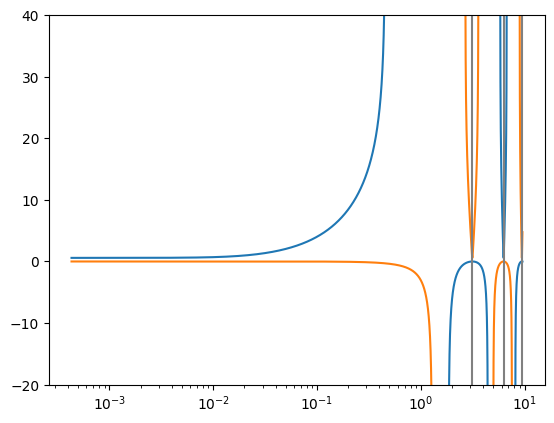

In [9]:
plt.plot(w * tc, 20 * np.log10(S_si_ipsi_I))
plt.plot(w * tc, 20 * np.log10(S_si_ipsi_II))
plt.axvline(1 * np.pi, color='gray')
plt.axvline(2 * np.pi, color='gray')
plt.axvline(3 * np.pi, color='gray')
plt.xscale('log')
plt.ylim(-20, 40)
plt.show()

In [10]:
# Calculate spectral amplitudes
# Side image at ipsi ear @Branch I
E_si_ipsi_I  = ( x*r*r*(g*g-x+1) + (r*r*g+r) * np.sqrt(g*g-x+1)) / (1+g*g-x+2*r*x*np.sqrt(g*g-x+1))
# Side image at ipsi ear @Branch II
E_si_ipsi_II = (-x*r*r*(g*g+x+1) + (r*r*g+r) * np.sqrt(g*g+x+1)) / (1+g*g+x-2*r*x*np.sqrt(g*g+x+1))
# Side image at ipsi ear @Branch Perfect
E_si_ipsi_P  = np.ones_like(w) * r

C:\Users\kweiwent\AppData\Local\Temp\ipykernel_4732\771453753.py:1: RuntimeWarning: invalid value encountered in log10
  plt.plot(w * tc, 20 * np.log10(E_si_ipsi_I))
C:\Users\kweiwent\AppData\Local\Temp\ipykernel_4732\771453753.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(w * tc, 20 * np.log10(E_si_ipsi_II))


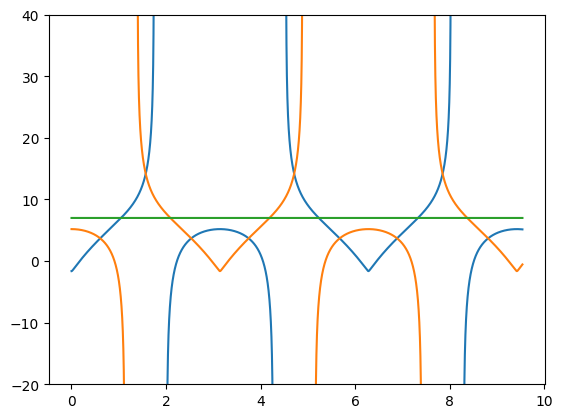

In [11]:
plt.plot(w * tc, 20 * np.log10(E_si_ipsi_I))
plt.plot(w * tc, 20 * np.log10(E_si_ipsi_II))
plt.plot(w * tc, 20 * np.log10(E_si_ipsi_P))
# plt.xscale('log')
# plt.axvline(np.pi)
plt.ylim(-20, 40)
plt.show()